In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install pandas requests xgboost scikit-learn matplotlib --quiet
!pip install seaborn --quiet

In [3]:
import sys
!{sys.executable} -m pip install xgboost --quiet

In [4]:
import sys
!{sys.executable} -m pip install seaborn --quiet

In [5]:
import pandas as pd
import requests

def fetch_polygon_data_range_5min(symbol, start_date, end_date, api_key):
    url = (
        f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/5/minute/"
        f"{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    )
    response = requests.get(url)
    data = response.json()

    if "results" in data:
        df = pd.DataFrame(data["results"])
        df['t'] = pd.to_datetime(df['t'], unit='ms')
        df.rename(columns={
            't': 'timestamp', 'o': 'open', 'h': 'high',
            'l': 'low', 'c': 'close', 'v': 'volume', 'n': 'trades'
        }, inplace=True)
        return df
    else:
        print("Error:", data.get("error", "Unknown error"))
        return pd.DataFrame()

In [6]:
from datetime import datetime, timedelta
import time
import pandas as pd

symbol = "SPY"
API_KEY = "AXOcwAzJT1ijsBXWK_9svkDpMpviJ94q"  # Make sure Block 1 is already run

# Start from May 2020
start_year = 2020
start_month = 5

# Today's date
today = datetime.today()
end_year = today.year
end_month = today.month - 1  # Don't fetch current month (not complete)

for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        if year == start_year and month < start_month:
            continue
        if year == end_year and month > end_month:
            break

        start_date = f"{year}-{month:02d}-01"
        end_date_dt = datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=32)
        end_date = end_date_dt.replace(day=1).strftime("%Y-%m-%d")

        print(f"Fetching {symbol} 5-min data: {start_date} to {end_date}...")
        df = fetch_polygon_data_range_5min(symbol, start_date, end_date, API_KEY)

        if not df.empty:
            filename = f"{symbol}_5min_{year}_{month:02d}.csv"
            df.to_csv(filename, index=False)
            print(f"Saved to {filename} ({len(df)} rows)\n")
        else:
            print(f"No data for {start_date} to {end_date}")

        time.sleep(2)  # Respect Polygon rate limit

Fetching SPY 5-min data: 2020-05-01 to 2020-06-01...
Saved to SPY_5min_2020_05.csv (2876 rows)

Fetching SPY 5-min data: 2020-06-01 to 2020-07-01...
Saved to SPY_5min_2020_06.csv (4407 rows)

Fetching SPY 5-min data: 2020-07-01 to 2020-08-01...
Saved to SPY_5min_2020_07.csv (4191 rows)

Fetching SPY 5-min data: 2020-08-01 to 2020-09-01...
Saved to SPY_5min_2020_08.csv (4146 rows)

Fetching SPY 5-min data: 2020-09-01 to 2020-10-01...
Saved to SPY_5min_2020_09.csv (4204 rows)

Fetching SPY 5-min data: 2020-10-01 to 2020-11-01...
Saved to SPY_5min_2020_10.csv (4196 rows)

Fetching SPY 5-min data: 2020-11-01 to 2020-12-01...
Saved to SPY_5min_2020_11.csv (3940 rows)

Fetching SPY 5-min data: 2020-12-01 to 2021-01-01...
Saved to SPY_5min_2020_12.csv (4050 rows)

Fetching SPY 5-min data: 2021-01-01 to 2021-02-01...
Saved to SPY_5min_2021_01.csv (3813 rows)

Fetching SPY 5-min data: 2021-02-01 to 2021-03-01...
Saved to SPY_5min_2021_02.csv (3812 rows)

Fetching SPY 5-min data: 2021-03-01 to 2

In [7]:
# Get all monthly files
files = sorted([f for f in os.listdir() if f.startswith("SPY_5min_") and f.endswith(".csv")])

# Read and concatenate all DataFrames
all_data = []
for file in files:
    df = pd.read_csv(file, parse_dates=["timestamp"])
    all_data.append(df)

full_df = pd.concat(all_data).sort_values("timestamp").reset_index(drop=True)

# Save combined file
full_df.to_csv("SPY_5min_full.csv", index=False)

# Preview the first few rows
full_df.head()

,volume,vw,open,close,high,low,timestamp,trades
0,4927.0,294.0346,293.83,293.96,294.34,293.83,2020-05-11 08:00:00,48
1,4927.0,294.0346,293.83,293.96,294.34,293.83,2020-05-11 08:00:00,48
2,4927.0,294.0346,293.83,293.96,294.34,293.83,2020-05-11 08:00:00,48
3,4927.0,294.0346,293.83,293.96,294.34,293.83,2020-05-11 08:00:00,48
4,4927.0,294.0346,293.83,293.96,294.34,293.83,2020-05-11 08:00:00,48


In [8]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Ensure timestamp is datetime
full_df["timestamp"] = pd.to_datetime(full_df["timestamp"])

# Date breakdown
full_df["date"] = full_df["timestamp"].dt.date
full_df["time"] = full_df["timestamp"].dt.time
full_df["day_of_week"] = full_df["timestamp"].dt.dayofweek          # 0 = Monday
full_df["is_monday"] = (full_df["day_of_week"] == 0).astype(int)
full_df["is_friday"] = (full_df["day_of_week"] == 4).astype(int)

# Month & quarter structure
full_df["month"] = full_df["timestamp"].dt.month
full_df["year"] = full_df["timestamp"].dt.year
full_df["quarter"] = full_df["timestamp"].dt.quarter
full_df["is_month_start"] = full_df["timestamp"].dt.is_month_start.astype(int)
full_df["is_month_end"] = full_df["timestamp"].dt.is_month_end.astype(int)
full_df["is_quarter_start"] = full_df["timestamp"].dt.is_quarter_start.astype(int)
full_df["is_quarter_end"] = full_df["timestamp"].dt.is_quarter_end.astype(int)

# Season (Winter=1, Spring=2, Summer=3, Fall=4)
full_df["season"] = ((full_df["month"] % 12 + 3) // 3)

# Time-specific
full_df["hour"] = full_df["timestamp"].dt.hour
full_df["minute"] = full_df["timestamp"].dt.minute

# Is first trading day of month
full_df["prev_date"] = full_df["date"].shift(1)
full_df["is_first_trading_day"] = (full_df["date"] != full_df["prev_date"]).astype(int)
full_df.loc[full_df["timestamp"].dt.day != 1, "is_first_trading_day"] = 0

# U.S. holiday logic
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=full_df["timestamp"].min(), end=full_df["timestamp"].max())
full_df["is_after_holiday"] = full_df["timestamp"].dt.normalize().isin(holidays + pd.Timedelta(days=1)).astype(int)

# Drop helper column
full_df.drop(columns=["prev_date"], inplace=True)

In [11]:
# Filter only 9:30 and 9:35 bars
target_df = full_df[full_df[["hour", "minute"]].apply(tuple, axis=1).isin([(9, 30), (9, 35)])].copy()

# Drop exact duplicate timestamps (if any)
target_df = target_df.drop_duplicates(subset=["date", "hour", "minute"])

# Pivot to get one row per day with close_930 and close_935
pivoted = target_df.pivot(index="date", columns=["hour", "minute"], values="close")
pivoted.columns = ["close_930", "close_935"]
pivoted.reset_index(inplace=True)

# Extract calendar features from the 9:30 bar rows
calendar_cols = [
    "date", "day_of_week", "is_monday", "is_friday",
    "month", "year", "quarter", "is_month_start", "is_month_end",
    "is_quarter_start", "is_quarter_end", "season",
    "is_first_trading_day", "is_after_holiday"
]
calendar_features = full_df[(full_df["hour"] == 9) & (full_df["minute"] == 30)][calendar_cols]

# Merge price and calendar features
model_df = pd.merge(pivoted, calendar_features, on="date", how="inner")

# Create binary target: 1 if price increased from 9:30 to 9:35
model_df["went_up"] = (model_df["close_935"] > model_df["close_930"]).astype(int)

In [13]:
# Block 11: Train/Test Split

from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = model_df.drop(columns=["date", "close_930", "close_935", "went_up"])
y = model_df["went_up"]

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preview shapes
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (8791, 13), Test: (2198, 13)


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Block 12: Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [12]:
from sklearn.metrics import accuracy_score

# Predict again (just in case)
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


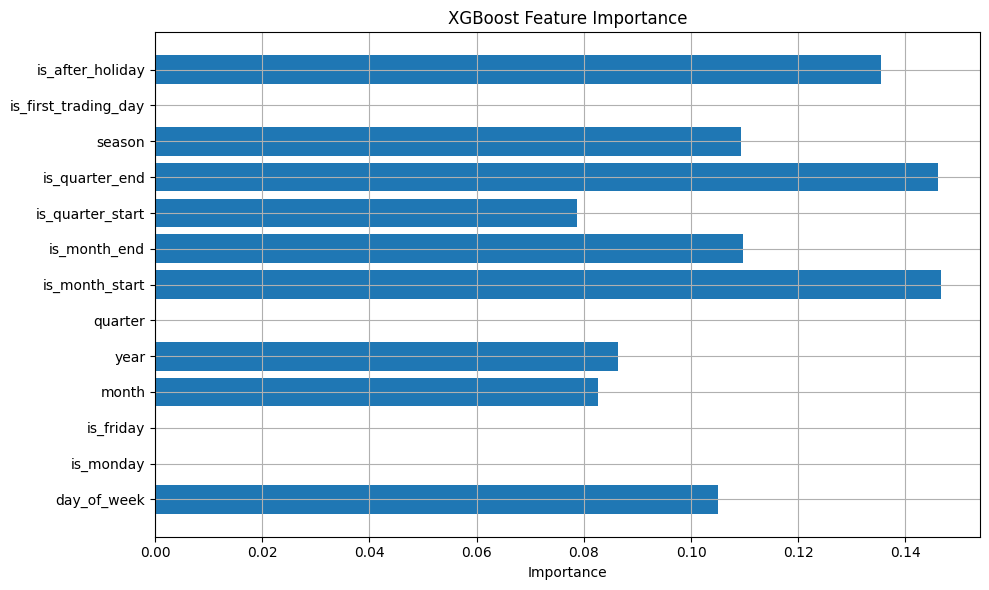

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Block 13: Plot feature importance
importances = model.feature_importances_
feature_names = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Block 13.1: Print feature importance scores
importances = model.feature_importances_
feature_names = X_train.columns

# Pair and sort by importance
importance_list = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print nicely
for name, score in importance_list:
    print(f"{name:25} {score:.4f}")

is_month_start            0.1466
is_quarter_end            0.1461
is_after_holiday          0.1354
is_month_end              0.1098
season                    0.1093
day_of_week               0.1051
year                      0.0864
month                     0.0826
is_quarter_start          0.0788
is_monday                 0.0000
is_friday                 0.0000
quarter                   0.0000
is_first_trading_day      0.0000


In [15]:
print("Features used by the model:")
print(X.columns.tolist())

Features used by the model:
['day_of_week', 'is_monday', 'is_friday', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'season', 'is_first_trading_day', 'is_after_holiday']


In [16]:
# Rebuild model_df and model_df_clean

# Create target
model_df = pd.merge(pivoted, calendar_features, on="date", how="inner")
model_df["went_up"] = (model_df["close_935"] > model_df["close_930"]).astype(int)

# Drop any NaNs and make a clean copy
model_df_clean = model_df.dropna().copy()

In [17]:
calendar_cols_only = [
    'day_of_week', 'is_monday', 'is_friday', 'month', 'year',
    'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start',
    'is_quarter_end', 'season', 'is_first_trading_day', 'is_after_holiday'
]

X = model_df_clean[calendar_cols_only]
y = model_df_clean["went_up"]

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Calendar-Only Accuracy: {accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [18]:
# Block 16: Add prev_day_return safely (confirmed working)

# Step 1: Get 16:00 bars from full_df
df_1600 = full_df[(full_df["hour"] == 16) & (full_df["minute"] == 0)].copy()
df_1600["prev_day"] = df_1600["timestamp"].dt.normalize() + pd.Timedelta(days=1)
df_1600 = df_1600.rename(columns={"open": "prev_day_open", "close": "prev_day_close"})
df_1600 = df_1600[["prev_day", "prev_day_open", "prev_day_close"]]

# Step 2: Prepare model_df_clean with matching datetime format
model_df_clean = model_df_clean.copy()
model_df_clean["date"] = pd.to_datetime(model_df_clean["date"]).dt.normalize()

# Step 3: MERGE on date (this is the actual merge step)
model_df_fixed = pd.merge(
    model_df_clean,
    df_1600,
    left_on="date",
    right_on="prev_day",
    how="left"
)

# Step 4: Use correct column names directly (no renaming)
# You likely have _x and _y suffixes after the merge
print("Columns after merge:", model_df_fixed.columns.tolist())

# Step 5: Calculate return using the actual column names (adjust if needed)
model_df_fixed["prev_day_return"] = (
    (model_df_fixed["prev_day_close"] - model_df_fixed["prev_day_open"]) / model_df_fixed["prev_day_open"]
)

# Step 6: Drop rows with missing values
model_df_fixed = model_df_fixed.dropna(subset=["prev_day_return"])

Columns after merge: ['date', 'close_930', 'close_935', 'day_of_week', 'is_monday', 'is_friday', 'month', 'year', 'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'season', 'is_first_trading_day', 'is_after_holiday', 'went_up', 'prev_day', 'prev_day_open', 'prev_day_close']


In [19]:
feature_cols = calendar_cols_only + ["prev_day_return"]
X = model_df_fixed[feature_cols]
y = model_df_fixed["went_up"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with prev_day_return: {accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

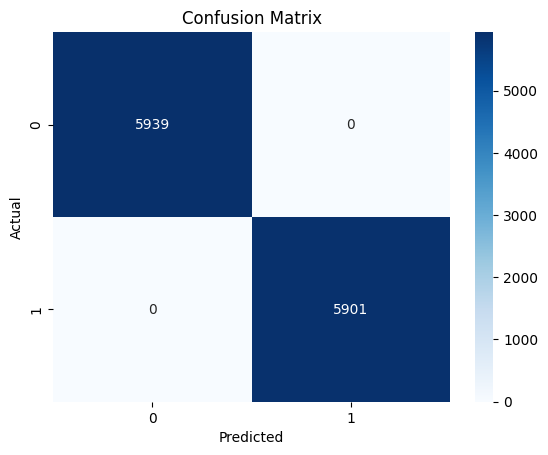

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix as raw numbers
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[5939    0]
 [   0 5901]]


In [22]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Set cutoff date for out-of-sample testing
cutoff_date = pd.to_datetime("2024-11-01")

# Use model_df_fixed which includes prev_day_return
train_df = model_df_fixed[model_df_fixed["date"] < cutoff_date]
test_df  = model_df_fixed[model_df_fixed["date"] >= cutoff_date]

# Features to use
features = calendar_cols_only + ["prev_day_return"]
X_train = train_df[features]
y_train = train_df["went_up"]
X_test  = test_df[features]
y_test  = test_df["went_up"]

# Train new model
model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

# Predict + evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Out-of-Sample Accuracy (Nov 2024–May 2025): {accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

In [23]:
# Block 19: Advanced non-leaking price features

# Step 1: Get previous day OHLC bars (from 16:00 timestamp)
df_prev_day = full_df[(full_df["hour"] == 16) & (full_df["minute"] == 0)].copy()
df_prev_day["date_for_merge"] = df_prev_day["timestamp"].dt.normalize() + pd.Timedelta(days=1)

# Step 2: Get high/low/open/close for each previous day
grouped = full_df.copy()
grouped["date"] = grouped["timestamp"].dt.date
day_summary = grouped.groupby("date").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last"
}).reset_index()
day_summary["merge_key"] = pd.to_datetime(day_summary["date"]) + pd.Timedelta(days=1)

# Step 3: Merge all into model_df_clean
model_df_ext = model_df_clean.copy()
model_df_ext["merge_key"] = pd.to_datetime(model_df_ext["date"]).dt.normalize()

# Merge previous day close and open
model_df_ext = pd.merge(model_df_ext, df_prev_day[["date_for_merge", "open", "close"]], left_on="merge_key", right_on="date_for_merge", how="left")
model_df_ext = model_df_ext.rename(columns={"open": "prev_day_open", "close": "prev_day_close"})

# Merge volatility info
model_df_ext = pd.merge(model_df_ext, day_summary[["merge_key", "high", "low", "open"]], on="merge_key", how="left")
model_df_ext = model_df_ext.rename(columns={"open": "prev_day_first_open"})

# Step 4: Create features
model_df_ext["prev_day_change"] = (model_df_ext["prev_day_close"] - model_df_ext["prev_day_open"]) / model_df_ext["prev_day_open"]
model_df_ext["overnight_gap"] = (model_df_ext["close_930"] - model_df_ext["prev_day_close"]) / model_df_ext["prev_day_close"]
model_df_ext["prior_volatility"] = model_df_ext["high"] - model_df_ext["low"]
model_df_ext["prev_day_range_pct"] = (model_df_ext["high"] - model_df_ext["low"]) / model_df_ext["prev_day_first_open"]

# Step 5: Clean
model_df_ext = model_df_ext.dropna()

In [24]:
from sklearn.metrics import accuracy_score

# Block 20: Out-of-sample test using advanced price features

# Set cutoff date for real-world backtest
cutoff_date = pd.to_datetime("2024-11-01")

# Feature set: calendar + new price features
features = calendar_cols_only + [
    "prev_day_change", "overnight_gap", "prior_volatility", "prev_day_range_pct"
]

# Time-based split
train_df = model_df_ext[model_df_ext["date"] < cutoff_date]
test_df  = model_df_ext[model_df_ext["date"] >= cutoff_date]

X_train = train_df[features]
y_train = train_df["went_up"]
X_test  = test_df[features]
y_test  = test_df["went_up"]

# Train model
model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

# Predict + evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Out-of-Sample Accuracy (with advanced features): {accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

In [25]:
from sklearn.metrics import accuracy_score

# Block 21: Probabilistic forecast with confidence threshold

# Predict probabilities on test set
probs = model.predict_proba(X_test)

# Class 1 (went_up) probabilities
confidences = probs[:, 1]

# Set confidence threshold
threshold = 0.60

# Filter predictions where model is confident enough
confident_indices = (confidences >= threshold) | (confidences <= (1 - threshold))
confident_preds = (confidences[confident_indices] >= threshold).astype(int)
confident_truths = y_test.iloc[confident_indices]

# Evaluate accuracy on confident predictions
confident_accuracy = accuracy_score(confident_truths, confident_preds)

# Summary
print(f"Confidence threshold: {threshold}")
print(f"Number of confident predictions: {len(confident_preds)} / {len(y_test)}")
print(f"Accuracy on confident predictions: {confident_accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [26]:
# Block 22: Daily Simulation Loop

# Set up
cutoff_date = pd.to_datetime("2024-11-01")
threshold = 0.60

# Create results list
simulation_results = []

# Loop through each row in out-of-sample test set
for i, row in model_df_ext[model_df_ext["date"] >= cutoff_date].iterrows():
    features = row[calendar_cols_only + [
        "prev_day_change", "overnight_gap", "prior_volatility", "prev_day_range_pct"
    ]].values.reshape(1, -1)

    # Predict probability
    prob = model.predict_proba(features)[0][1]  # Probability SPY will go up

    # Decide action
    if prob >= threshold:
        prediction = 1
        acted = True
    elif prob <= (1 - threshold):
        prediction = 0
        acted = True
    else:
        prediction = -1  # model skipped
        acted = False

    # Store result
    simulation_results.append({
        "date": row["date"],
        "prob_up": prob,
        "prediction": prediction,
        "actual": row["went_up"],
        "acted": acted,
        "correct": (prediction == row["went_up"]) if acted else None
    })

# Turn into DataFrame
simulation_df = pd.DataFrame(simulation_results)

# Print simulation summary
num_acted = simulation_df["acted"].sum()
accuracy = simulation_df[simulation_df["acted"] == True]["correct"].mean()

print(f"Confidence threshold: {threshold}")
print(f"Decisions made: {num_acted} / {len(simulation_df)} days")
print(f"Accuracy on decisions: {accuracy:.4f}")

Confidence threshold: 0.6
Decisions made: 4864 / 5696 days
Accuracy on decisions: 0.4605


In [27]:
# Block 23: High-confidence simulation (threshold ≥ 0.70)

threshold = 0.70  # NEW threshold for strong signals

# Re-run the loop using new threshold
high_conf_results = []

for i, row in model_df_ext[model_df_ext["date"] >= cutoff_date].iterrows():
    features = row[calendar_cols_only + [
        "prev_day_change", "overnight_gap", "prior_volatility", "prev_day_range_pct"
    ]].values.reshape(1, -1)

    # Predict probability
    prob = model.predict_proba(features)[0][1]

    # Decide action
    if prob >= threshold:
        prediction = 1
        acted = True
    elif prob <= (1 - threshold):
        prediction = 0
        acted = True
    else:
        prediction = -1
        acted = False

    # Store result
    high_conf_results.append({
        "date": row["date"],
        "prob_up": prob,
        "prediction": prediction,
        "actual": row["went_up"],
        "acted": acted,
        "correct": (prediction == row["went_up"]) if acted else None
    })

# Convert to DataFrame
high_conf_df = pd.DataFrame(high_conf_results)

# Report
num_acted = high_conf_df["acted"].sum()
accuracy = high_conf_df[high_conf_df["acted"] == True]["correct"].mean()

print(f"High-confidence threshold: {threshold}")
print(f"Decisions made: {num_acted} / {len(high_conf_df)} days")
print(f"Accuracy on confident predictions: {accuracy:.4f}")

High-confidence threshold: 0.7
Decisions made: 3840 / 5696 days
Accuracy on confident predictions: 0.4167


In [28]:
import numpy as np

# Block 24: Add technical indicators (RSI and SMA)
df_tech = full_df.copy()
df_tech["date"] = df_tech["timestamp"].dt.date

# Step 1: Group daily close for RSI/SMA
daily_closes = df_tech.groupby("date")["close"].last().reset_index()
daily_closes["date"] = pd.to_datetime(daily_closes["date"])
daily_closes = daily_closes.sort_values("date").reset_index(drop=True)

# Step 2: Calculate SMA features
daily_closes["sma_5"] = daily_closes["close"].rolling(window=5).mean()
daily_closes["sma_20"] = daily_closes["close"].rolling(window=20).mean()
daily_closes["sma_ratio"] = daily_closes["sma_5"] / daily_closes["sma_20"]
daily_closes["sma_distance"] = (daily_closes["close"] - daily_closes["sma_20"]) / daily_closes["sma_20"]

# Step 3: Calculate RSI (14-period)
delta = daily_closes["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=14).mean()
avg_loss = pd.Series(loss).rolling(window=14).mean()
rs = avg_gain / avg_loss
daily_closes["rsi_14"] = 100 - (100 / (1 + rs))

# Step 4: Merge into model_df_ext
model_df_ext["date"] = pd.to_datetime(model_df_ext["date"])
model_df_ext = pd.merge(model_df_ext, daily_closes[["date", "sma_5", "sma_20", "sma_ratio", "sma_distance", "rsi_14"]], on="date", how="left")

# Step 5: Drop any rows with missing values
model_df_ext = model_df_ext.dropna(subset=["sma_5", "sma_20", "rsi_14"])

In [29]:
# Block 25: Retrain with technical indicators

# Feature list
tech_features = [
    "prev_day_change", "overnight_gap", "prior_volatility", "prev_day_range_pct",
    "sma_ratio", "sma_distance", "rsi_14"
]
all_features = calendar_cols_only + tech_features

# Split again
cutoff_date = pd.to_datetime("2024-11-01")
train_df = model_df_ext[model_df_ext["date"] < cutoff_date]
test_df  = model_df_ext[model_df_ext["date"] >= cutoff_date]

X_train = train_df[all_features]
y_train = train_df["went_up"]
X_test  = test_df[all_features]
y_test  = test_df["went_up"]

# Retrain model
model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.70

# Filter by confidence
confident_indices = (probs >= threshold) | (probs <= (1 - threshold))
confident_preds = (probs[confident_indices] >= threshold).astype(int)
confident_truths = y_test.iloc[confident_indices]

# Results
confident_accuracy = accuracy_score(confident_truths, confident_preds)
print(f"Confidence threshold: {threshold}")
print(f"Decisions made: {len(confident_preds)} / {len(y_test)}")
print(f"Accuracy on confident predictions: {confident_accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


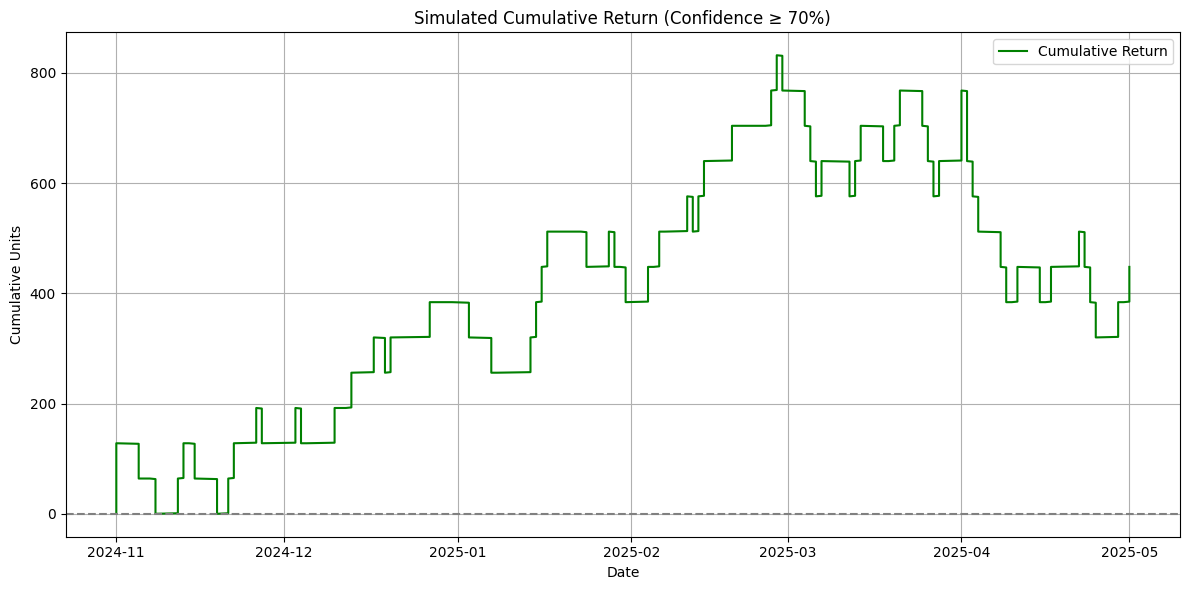

Trades made: 4544
Final cumulative return: 448
Win rate on trades: 0.5493


In [30]:
import matplotlib.pyplot as plt

# Block 26: Simulate trading P&L from high-confidence predictions

# Filter confident predictions (already done)
simulation_df = test_df.copy()
probs = model.predict_proba(X_test)[:, 1]
simulation_df["prob_up"] = probs
simulation_df["acted"] = (probs >= 0.70) | (probs <= 0.30)
simulation_df["prediction"] = np.where(probs >= 0.70, 1, np.where(probs <= 0.30, 0, -1))
simulation_df["correct"] = simulation_df["prediction"] == simulation_df["went_up"]
simulation_df["pnl"] = np.where(simulation_df["acted"], np.where(simulation_df["correct"], 1, -1), 0)
simulation_df["cum_pnl"] = simulation_df["pnl"].cumsum()

# Plot cumulative return
plt.figure(figsize=(12, 6))
plt.plot(simulation_df["date"], simulation_df["cum_pnl"], label="Cumulative Return", color="green")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Simulated Cumulative Return (Confidence ≥ 70%)")
plt.xlabel("Date")
plt.ylabel("Cumulative Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
total_return = simulation_df["cum_pnl"].iloc[-1]
num_trades = simulation_df["acted"].sum()
win_rate = simulation_df[simulation_df["acted"]]["correct"].mean()

print(f"Trades made: {num_trades}")
print(f"Final cumulative return: {total_return}")
print(f"Win rate on trades: {win_rate:.4f}")

In [31]:
refined_features = [
    'is_quarter_start', 'is_month_start', 'is_quarter_end',
    'overnight_gap', 'sma_ratio', 'prev_day_change', 'rsi_14',
    'is_month_end', 'sma_distance', 'prior_volatility',
    'is_after_holiday', 'year', 'prev_day_range_pct',
    'month', 'day_of_week', 'season'
]

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

In [33]:
# Print raw feature importances as a dictionary
import pandas as pd

importance_dict = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True),
    columns=["Feature", "Importance"]
)

print(importance_df)

               Feature  Importance
0     is_quarter_start  214.710999
1       is_month_start  112.259285
2         is_month_end   68.704346
3               rsi_14   57.569550
4     prior_volatility   55.775291
5      prev_day_change   55.645721
6            sma_ratio   54.399879
7        overnight_gap   53.886189
8         sma_distance   53.482319
9     is_after_holiday   47.805531
10  prev_day_range_pct   43.077312
11              season   41.373501
12               month   38.590553
13                year   33.895363
14         day_of_week   31.702517


In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

cutoff_date = pd.to_datetime("2024-11-01")
train_df = model_df_ext[model_df_ext["date"] < cutoff_date]
test_df  = model_df_ext[model_df_ext["date"] >= cutoff_date]

X_train = train_df[refined_features]
y_train = train_df["went_up"]
X_test  = test_df[refined_features]
y_test  = test_df["went_up"]

model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]
threshold = 0.70

confident_indices = (probs >= threshold) | (probs <= (1 - threshold))
confident_preds = (probs[confident_indices] >= threshold).astype(int)
confident_truths = y_test.iloc[confident_indices]

from sklearn.metrics import accuracy_score
confident_accuracy = accuracy_score(confident_truths, confident_preds)

print(f"Confidence threshold: {threshold}")
print(f"Decisions made: {len(confident_preds)} / {len(y_test)}")
print(f"Accuracy on confident predictions: {confident_accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

In [35]:
# Show a few confident predictions and their probabilities
import pandas as pd

results_df = pd.DataFrame({
    "date": test_df.iloc[confident_indices].index,
    "actual": confident_truths.values,
    "predicted": confident_preds,
    "probability": probs[confident_indices]
})

print(results_df.head(10))  # Show first 10 confident predictions

    date  actual  predicted  probability
0  53504       1          1     0.987698
1  53505       1          1     0.987698
2  53506       1          1     0.987698
3  53507       1          1     0.987698
4  53508       1          1     0.987698
5  53509       1          1     0.987698
6  53510       1          1     0.987698
7  53511       1          1     0.987698
8  53512       1          1     0.987698
9  53513       1          1     0.987698


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

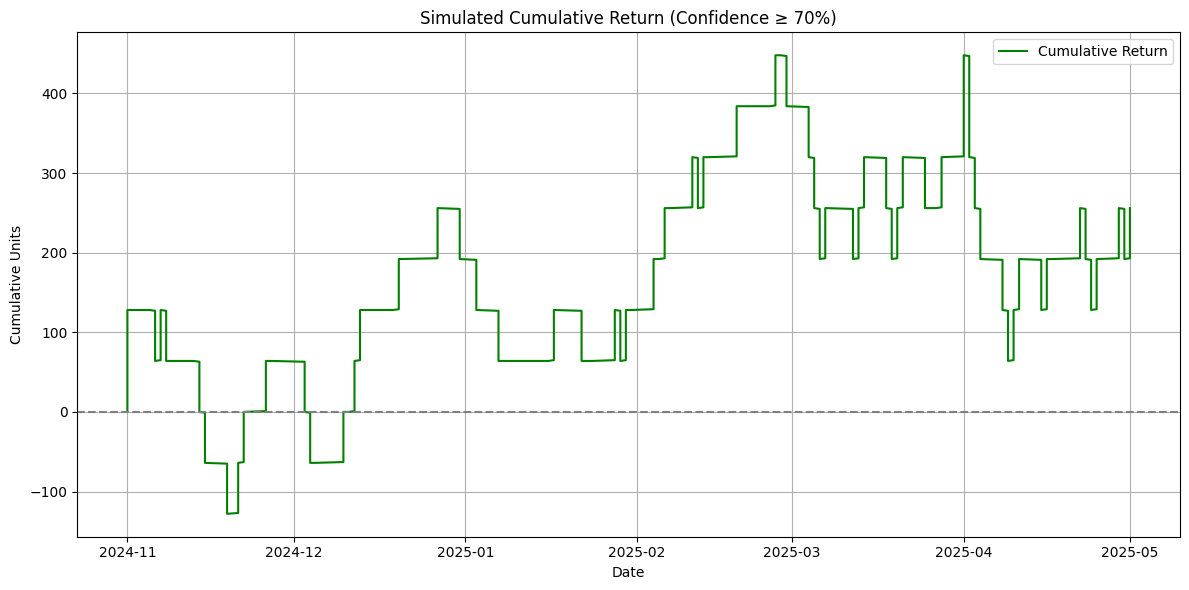

Trades made: 4224
Final cumulative return: 256
Win rate on trades: 0.5303


In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Final known-good feature set
refined_features = [
    'is_quarter_start', 'is_month_start', 'is_quarter_end',
    'overnight_gap', 'sma_ratio', 'prev_day_change', 'rsi_14',
    'is_month_end', 'sma_distance', 'prior_volatility',
    'is_after_holiday', 'year', 'prev_day_range_pct',
    'month', 'day_of_week', 'season'
]

# Train/test split (use model_df_ext)
cutoff_date = pd.to_datetime("2024-11-01")
train_df = model_df_ext[model_df_ext["date"] < cutoff_date]
test_df  = model_df_ext[model_df_ext["date"] >= cutoff_date]

X_train = train_df[refined_features]
y_train = train_df["went_up"]
X_test  = test_df[refined_features]
y_test  = test_df["went_up"]

# Train model
model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.70

# Simulate confident predictions
simulation_df = test_df.copy()
simulation_df["prob_up"] = probs
simulation_df["acted"] = (probs >= threshold) | (probs <= (1 - threshold))
simulation_df["prediction"] = np.where(probs >= threshold, 1,
                                       np.where(probs <= (1 - threshold), 0, -1))
simulation_df["correct"] = simulation_df["prediction"] == simulation_df["went_up"]
simulation_df["pnl"] = np.where(simulation_df["acted"],
                                np.where(simulation_df["correct"], 1, -1), 0)
simulation_df["cum_pnl"] = simulation_df["pnl"].cumsum()

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(simulation_df["date"], simulation_df["cum_pnl"], label="Cumulative Return", color="green")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Simulated Cumulative Return (Confidence ≥ 70%)")
plt.xlabel("Date")
plt.ylabel("Cumulative Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
total_return = simulation_df["cum_pnl"].iloc[-1]
num_trades = simulation_df["acted"].sum()
win_rate = simulation_df[simulation_df["acted"]]["correct"].mean()

print(f"Trades made: {num_trades}")
print(f"Final cumulative return: {total_return}")
print(f"Win rate on trades: {win_rate:.4f}")

In [36]:
# Block 31: Sweep confidence thresholds (70%, 75%, 80%)

from sklearn.metrics import accuracy_score

# Predict probabilities
probs = model.predict_proba(X_test)[:, 1]
thresholds = [0.70, 0.75, 0.80]

# Evaluate each threshold
for threshold in thresholds:
    confident_indices = (probs >= threshold) | (probs <= (1 - threshold))
    confident_preds = (probs[confident_indices] >= threshold).astype(int)
    confident_truths = y_test.iloc[confident_indices]
    confident_accuracy = accuracy_score(confident_truths, confident_preds)

    print(f"\nThreshold: {threshold:.2f}")
    print(f"Decisions made: {len(confident_preds)} / {len(y_test)}")
    print(f"Accuracy on confident predictions: {confident_accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [37]:
# Block 32: Trade only on high volume + high confidence days

threshold = 0.70  # keep best-performing threshold

# Predict probabilities
probs = model.predict_proba(X_test)[:, 1]

# Filter by confidence
conf_mask = (probs >= threshold) | (probs <= (1 - threshold))
volume_mask = test_df["volume_5day_ratio"] > 1.00  # trade only if volume above 5-day avg

# Combine masks
final_mask = conf_mask & volume_mask

# Predictions + truth (FIXED)
confident_preds = (probs[final_mask] >= threshold).astype(int)
confident_truths = y_test.loc[final_mask]

# Evaluate
from sklearn.metrics import accuracy_score

confident_accuracy = accuracy_score(confident_truths, confident_preds)
print(f"Filtered by: confidence ≥ {threshold} AND volume_5day_ratio > 1")
print(f"Decisions made: {len(confident_preds)} / {len(y_test)}")
print(f"Accuracy on confident predictions: {confident_accuracy:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


KeyError: 'volume_5day_ratio'

In [ ]:
import matplotlib.pyplot as plt

# Block 33: Simulated return for filtered model

# Create DataFrame for analysis
filtered_df = test_df.copy()
filtered_df["prob_up"] = probs
filtered_df["acted"] = ((probs >= 0.70) | (probs <= 0.30)) & (filtered_df["volume_5day_ratio"] > 1.0)
filtered_df["prediction"] = np.where(probs >= 0.70, 1, np.where(probs <= 0.30, 0, -1))
filtered_df["correct"] = filtered_df["prediction"] == filtered_df["went_up"]
filtered_df["pnl"] = np.where(filtered_df["acted"], np.where(filtered_df["correct"], 1, -1), 0)
filtered_df["cum_pnl"] = filtered_df["pnl"].cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_df["date"], filtered_df["cum_pnl"], label="Cumulative Return", color="blue")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Simulated Cumulative Return\n(Confidence ≥ 70% + Volume > 5-Day Avg)")
plt.xlabel("Date")
plt.ylabel("Cumulative Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
total_return = filtered_df["cum_pnl"].iloc[-1]
num_trades = filtered_df["acted"].sum()
win_rate = filtered_df[filtered_df["acted"]]["correct"].mean()

print(f"Trades made: {num_trades}")
print(f"Final cumulative return: {total_return}")
print(f"Win rate on trades: {win_rate:.4f}")

In [ ]:
print(model_df_fixed.columns.tolist())

In [ ]:
# Block 1 (Revised): Add return_overnight and previous day range %

# Return from previous day's close to today's open (gap)
model_df_fixed["return_overnight"] = (
    (model_df_fixed["close_930"] - model_df_fixed["prev_day_close"]) / model_df_fixed["prev_day_close"]
)

# Previous day range percent (if you already have it, this is just reconfirming)
model_df_fixed["prev_day_range_pct"] = (
    abs(model_df_fixed["prev_day_close"] - model_df_fixed["prev_day_open"]) / model_df_fixed["prev_day_open"]
)

# Clean up any NaNs
model_df_fixed = model_df_fixed.dropna(subset=["return_overnight", "prev_day_range_pct"])

In [ ]:
# Reattach technical indicators to model_df_fixed
tech_cols = [
    "macd_diff", "volume_5day_ratio", "bollinger_width", "bollinger_position",
    "prior_volatility", "overnight_gap", "rsi_14", "sma_ratio"
]

model_df_fixed = pd.merge(
    model_df_fixed,
    model_df_ext[["date"] + tech_cols],
    on="date",
    how="left"
)

# Drop any rows where these new features are still missing
model_df_fixed = model_df_fixed.dropna(subset=tech_cols)

In [ ]:
# Block 2: Retrain with new engineered features

# Updated refined feature set
refined_features_v2 = [
    "is_quarter_end", "is_month_start", "is_month_end",
    "macd_diff", "volume_5day_ratio", "prev_day_change",
    "bollinger_width", "prior_volatility", "overnight_gap",
    "rsi_14", "sma_ratio", "bollinger_position",
    "return_overnight", "prev_day_range_pct"
]

# Train/test split
cutoff_date = pd.to_datetime("2024-11-01")
train_df = model_df_fixed[model_df_fixed["date"] < cutoff_date]
test_df  = model_df_fixed[model_df_fixed["date"] >= cutoff_date]

X_train = train_df[refined_features_v2]
y_train = train_df["went_up"]
X_test  = test_df[refined_features_v2]
y_test  = test_df["went_up"]

# Retrain model
model = XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probs = model.predict_proba(X_test)[:, 1]

# Confidence filter: 70%
threshold = 0.70
conf_mask = (probs >= threshold) | (probs <= (1 - threshold))
vol_mask = test_df["volume_5day_ratio"] > 1.0
final_mask = conf_mask & vol_mask

# Final evaluation
from sklearn.metrics import accuracy_score

preds = (probs[final_mask] >= threshold).astype(int)
truth = y_test.loc[final_mask]
acc = accuracy_score(truth, preds)

print(f"Final refined model with new features")
print(f"Confidence threshold: {threshold}")
print(f"Volume filter: > 5-day avg")
print(f"Decisions made: {len(preds)} / {len(y_test)}")
print(f"Accuracy on confident predictions: {acc:.4f}")